# DATA SCIENCE BCG INSIDE SHERPA CASE

PowerCo is looking to solve one of its problem to see whether price sensitivity can be used to predict customers behaviour to churn or not.

## Merging Data 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,  timedelta
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
dt1 = pd.read_csv('../Data/ml_case_training_data.csv')
print('Shape of the data: {0[0]} rows with {0[1]} columns.'.format(dt1.shape))

Shape of the data: 16096 rows with 32 columns.


In [3]:
dt2 = pd.read_csv('../Data/ml_case_training_hist_data.csv')
print('Shape of the data: {0[0]} rows with {0[1]} columns.'.format(dt2.shape))

Shape of the data: 193002 rows with 8 columns.


In [4]:
dt3 = pd.read_csv('../Data/ml_case_training_output.csv')
print('Shape of the data: {0[0]} rows with {0[1]} columns.'.format(dt3.shape))

Shape of the data: 16096 rows with 2 columns.


In [5]:
df = pd.merge(dt1, dt2, on = 'id')
df = pd.merge(df, dt3, on = 'id')
print('Shape of the data: {0[0]} rows with {0[1]} columns.'.format(df.shape))

Shape of the data: 193002 rows with 40 columns.


## Peeking and Cleaning the Data

In [6]:
# Find features with missing values and understand the missing values ratio.
def check_na(df):
    nas =  pd.DataFrame([(x, df[x].isnull().sum()*100/len(df)) for x in df]).rename(columns= {0: 'Nas_Features' , 1:'Missing Values Ratio'})
    
    if nas['Missing Values Ratio'].sum() == 0:
        print('No Missing Values Found.')
    else:
        return nas[nas['Missing Values Ratio'] != 0]

In [7]:
check_na(df)

,Nas_Features,Missing Values Ratio
1,activity_new,59.290577
2,campaign_disc_ele,100.000000
3,channel_sales,26.214754
8,date_end,0.010881
9,date_first_activ,78.216806
10,date_modif_prod,0.971493
11,date_renewal,0.247148
12,forecast_base_bill_ele,78.216806
13,forecast_base_bill_year,78.216806
14,forecast_bill_12m,78.216806


## Exploratory Data Analysis

Top 8 activity with customer churning at the end

In [8]:
df.groupby('activity_new').agg(sum)['churn'].sort_values(ascending = False)[0:8]

activity_new
apdekpcbwosbxepsfxclislboipuxpop    1116
kkklcdamwfafdcfwofuscwfwadblfmce     455
fmwdwsxillemwbbwelxsampiuwwpcdcb     384
kwuslieomapmswolewpobpplkaooaaew     359
wxemiwkumpibllwklfbcooafckufkdlm     204
cluecxlameloamldmasudocsbmaoamdw     168
ckfxocssowaeipxueikxcmaxdmcduxsa     156
cwofmuicebbcmiaaxufmfimpowpacobu     144
Name: churn, dtype: int64

Top 8 channel sales with customer churning at the end

In [9]:
df.groupby('channel_sales').agg(sum)['churn'].sort_values(ascending = False)[0:8]

channel_sales
foosdfpfkusacimwkcsosbicdxkicaua    11041
usilxuppasemubllopkaafesmlibmsdf     1798
lmkebamcaaclubfxadlmueccxoimlema     1390
ewpakwlliwisiwduibdlfmalxowmwpci      983
sddiedcslfslkckwlfkdpoeeailfpeds        0
fixdbufsefwooaasfcxdxadsiekoceaa        0
epumfxlbckeskwekxbiuasklxalciiuu        0
Name: churn, dtype: int64

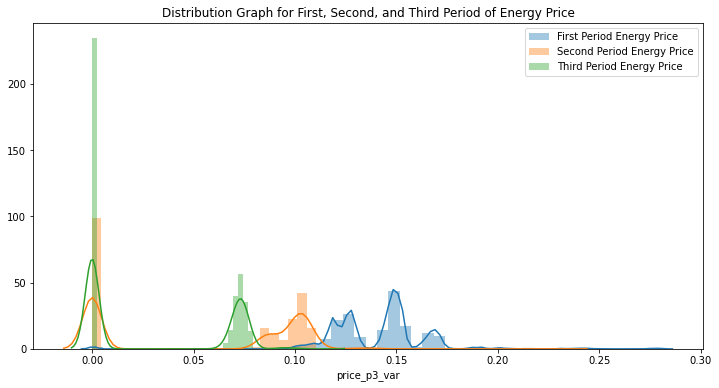

In [10]:
plt.figure(figsize = (12, 6))
sns.distplot(df['price_p1_var'], label = 'First Period Energy Price')
sns.distplot(df['price_p2_var'], label = 'Second Period Energy Price')
sns.distplot(df['price_p3_var'], label = 'Third Period Energy Price')
plt.title('Distribution Graph for First, Second, and Third Period of Energy Price')
plt.legend();

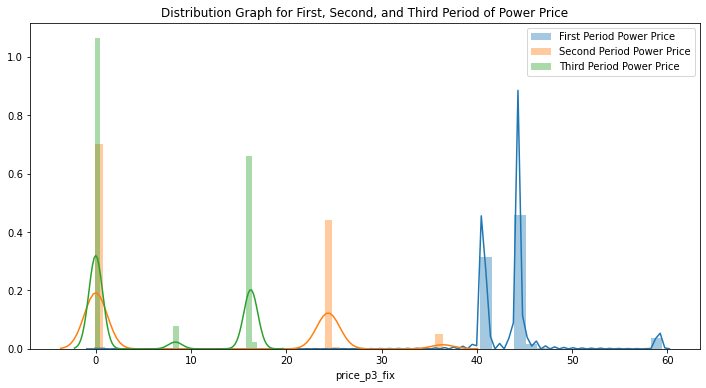

In [11]:
plt.figure(figsize = (12, 6))
sns.distplot(df['price_p1_fix'], label = 'First Period Power Price')
sns.distplot(df['price_p2_fix'], label = 'Second Period Power Price')
sns.distplot(df['price_p3_fix'], label = 'Third Period Power Price')
plt.title('Distribution Graph for First, Second, and Third Period of Power Price')
plt.legend();

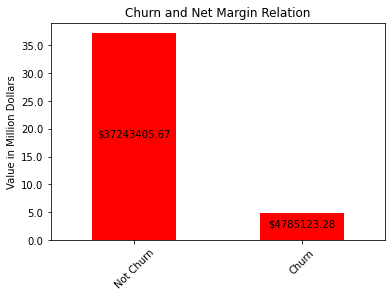

In [12]:
ax = df.groupby('churn').agg('sum')['net_margin'].plot(kind = 'bar', 
                                                       color = 'red', )

plt.title('Churn and Net Margin Relation')
plt.xticks([0, 1],['Not Churn', 'Churn'], rotation = 45)
plt.xlabel('')
plt.ylabel('Value in Million Dollars')

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x)/10**6, ',')))

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'${height:.2f}', (x + width/2, y + height*.5), ha='center')

**Identifying values with high correlation.**

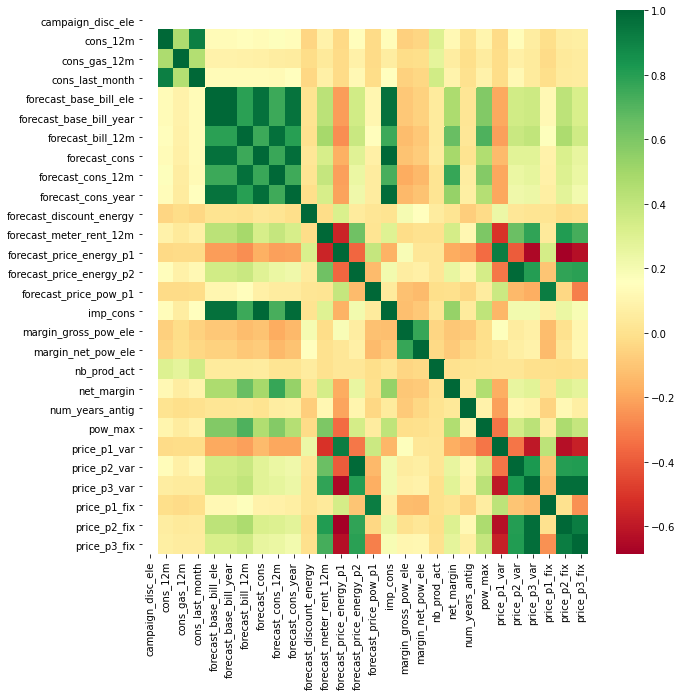

In [13]:
numeric_features =  df.drop('churn', axis = 1).dtypes[df.dtypes != 'object'].index

corrmat = df[numeric_features].corr()
plt.figure(figsize=(10,10))
g = sns.heatmap(corrmat,annot=False,cmap="RdYlGn")

### Simple Imputer to fill missing values with their average.

First we shall convert the skewed data into more of a normal distribution using log transformation.

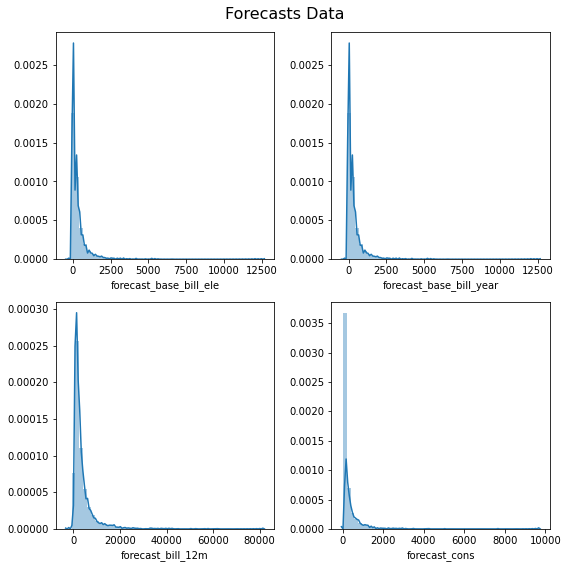

In [14]:
i = 1
fig, axs = plt.subplots(2, 2, figsize = (8, 8))
for x in ['forecast_base_bill_ele', 'forecast_base_bill_year', 
         'forecast_bill_12m', 'forecast_cons']:
    plt.subplot(2, 2, i)
    sns.distplot(df[x])
    df[x] = df[x].fillna(df[x].mean(skipna=True))
    i=i+1;
fig.suptitle('Forecasts Data', fontsize=16)
plt.tight_layout()

In [15]:
check_na(df)

,Nas_Features,Missing Values Ratio
1,activity_new,59.290577
2,campaign_disc_ele,100.000000
3,channel_sales,26.214754
8,date_end,0.010881
9,date_first_activ,78.216806
10,date_modif_prod,0.971493
11,date_renewal,0.247148
18,forecast_discount_energy,0.780821
20,forecast_price_energy_p1,0.780821
21,forecast_price_energy_p2,0.780821


Some features are filled with a lot of missing values. Also we have some columns that we probably won't need for this problem. The next step is to deal with this problem.

In [16]:
# Imputing Missing values on dates data

def impute_dates(df):
    columns_dates = ['date_modif_prod','date_end', 'date_renewal']
    
    for col in columns_dates:
        df.loc[df[col].isnull(), col] = df[col].value_counts().index[0]
impute_dates(df)

In [17]:
# Convert date information to date data type

def convert_to_dates(df):
    col_to_convert = ['date_activ', 'date_modif_prod',
                      'price_date', 'date_end', 'date_renewal']
    
    for col in col_to_convert:
        df[col] = pd.to_datetime(df[col], format = '%Y-%m-%d')
        
convert_to_dates(df)

In [19]:
# Replace Negative Values with averages.

def replace_negatives(df):
    col_to_find = df.drop('churn', axis = 1).dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index
    
    for x in list(col_to_find):
        df.loc[df[x] < 0 , x] = df.loc[df[x]>0, x].mean()
        
replace_negatives(df)

In [20]:
# Fill in Missing Categorical information

def fill_na(df):
    col_to_impute = ['activity_new', 'channel_sales', 'id', 'origin_up']
    
    for col in col_to_impute:
        
        name_ = 'Missing_' + col
        df[col_to_impute]= df[col_to_impute].fillna(name_)
        
fill_na(df)

In [21]:
# Fill in Missing Numeric Variable
def impute_numeric(df):
    col_to_find = df.drop('churn', axis = 1).dtypes[df.dtypes == 'float64'].index
    for x in list(col_to_find):
        median = df[x].median(skipna = True)
        df.loc[df[x].isnull(), x] = median
impute_numeric(df)

In [22]:
list_to_drop = ['campaign_disc_ele', 'date_first_activ']

df.drop(list_to_drop, inplace = True, axis = 1 ,errors = 'raise')

df.dropna(axis = 0, inplace = True)

In [23]:
check_na(df)
print('Shape of the data: {0[0]} rows with {0[1]} columns.'.format(df.shape))

No Missing Values Found.
Shape of the data: 193002 rows with 38 columns.


In [24]:
df

,id,activity_new,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,origin_up,pow_max,price_date,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix,churn
0,48ada52261e7cf58715202705a0451c9,esoiiifxdlbkcsluxmfuacbdckommixw,lmkebamcaaclubfxadlmueccxoimlema,309275.0,0.0,10025.0,2012-11-07,2016-11-06,2012-11-07,2015-11-09,...,ldkssxwpmemidmecebumciepifcamkci,180.000,2015-01-01,0.106043,0.093474,0.067378,58.936774,36.344726,8.33426,0
1,48ada52261e7cf58715202705a0451c9,esoiiifxdlbkcsluxmfuacbdckommixw,lmkebamcaaclubfxadlmueccxoimlema,309275.0,0.0,10025.0,2012-11-07,2016-11-06,2012-11-07,2015-11-09,...,ldkssxwpmemidmecebumciepifcamkci,180.000,2015-02-01,0.106043,0.093474,0.067378,58.936774,36.344726,8.33426,0
2,48ada52261e7cf58715202705a0451c9,esoiiifxdlbkcsluxmfuacbdckommixw,lmkebamcaaclubfxadlmueccxoimlema,309275.0,0.0,10025.0,2012-11-07,2016-11-06,2012-11-07,2015-11-09,...,ldkssxwpmemidmecebumciepifcamkci,180.000,2015-03-01,0.106043,0.093474,0.067378,58.936774,36.344726,8.33426,0
3,48ada52261e7cf58715202705a0451c9,esoiiifxdlbkcsluxmfuacbdckommixw,lmkebamcaaclubfxadlmueccxoimlema,309275.0,0.0,10025.0,2012-11-07,2016-11-06,2012-11-07,2015-11-09,...,ldkssxwpmemidmecebumciepifcamkci,180.000,2015-04-01,0.106043,0.093474,0.067378,58.936774,36.344726,8.33426,0
4,48ada52261e7cf58715202705a0451c9,esoiiifxdlbkcsluxmfuacbdckommixw,lmkebamcaaclubfxadlmueccxoimlema,309275.0,0.0,10025.0,2012-11-07,2016-11-06,2012-11-07,2015-11-09,...,ldkssxwpmemidmecebumciepifcamkci,180.000,2015-05-01,0.106043,0.093474,0.067378,58.936774,36.344726,8.33426,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192997,563dde550fd624d7352f3de77c0cdfcd,Missing_activity_new,Missing_activity_new,8730.0,0.0,0.0,2009-12-18,2016-12-17,2009-12-18,2015-12-21,...,ldkssxwpmemidmecebumciepifcamkci,10.392,2015-08-01,0.165962,0.086905,0.000000,44.266930,0.000000,0.00000,0
192998,563dde550fd624d7352f3de77c0cdfcd,Missing_activity_new,Missing_activity_new,8730.0,0.0,0.0,2009-12-18,2016-12-17,2009-12-18,2015-12-21,...,ldkssxwpmemidmecebumciepifcamkci,10.392,2015-09-01,0.165962,0.086905,0.000000,44.266930,0.000000,0.00000,0
192999,563dde550fd624d7352f3de77c0cdfcd,Missing_activity_new,Missing_activity_new,8730.0,0.0,0.0,2009-12-18,2016-12-17,2009-12-18,2015-12-21,...,ldkssxwpmemidmecebumciepifcamkci,10.392,2015-10-01,0.165962,0.086905,0.000000,44.266930,0.000000,0.00000,0
193000,563dde550fd624d7352f3de77c0cdfcd,Missing_activity_new,Missing_activity_new,8730.0,0.0,0.0,2009-12-18,2016-12-17,2009-12-18,2015-12-21,...,ldkssxwpmemidmecebumciepifcamkci,10.392,2015-11-01,0.165962,0.086905,0.000000,44.266930,0.000000,0.00000,0


In [25]:
df.to_csv('../Data/cleaned_data.csv')